# Project Pipeline

## 0. Import

In [1]:
!pip install Unidecode

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import json
import itertools
import unidecode

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

## 1. Tách dữ liệu để huấn luyện và kiểm thử
Mục đích của bước này là chia dữ liệu làm 2 phần, một phần để huấn luyện và phần còn lại coi như là thực tế và để đánh giá cuối cùng.
- Đầu vào: đường dẫn đến file dữ liệu đã crawl
- Đầu ra: 1 file train.csv và 1 file test.csv

In [3]:
def split_train_test(data_path, train_data_path, test_data_path):
    data_df = pd.read_csv(data_path, index_col=0)
    data_df.label.astype(int)
    
    train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=0)
    train_df.to_csv(train_data_path)
    test_df.to_csv(test_data_path)
    
split_train_test('../data/csv/vietnamnews.csv', '../data/csv/train.csv', '../data/csv/test.csv')

In [4]:
data_df = pd.read_csv('../data/csv/train.csv', index_col = 0)
data_df.label.astype(int)

data_df

,title,text,label
id,,,
3233,'Friendly visa policies help VN\xa0greet more ...,Experts told\xa0Việt Nam News reporter Nguyễn ...,2
5344,'PM calls for joint action to deal with plasti...,'Prime Minister Nguyễn Xuân Phúc has written a...,4
613,'Meetings held leading to ASEAN Summit',Leaders of delegations at the preparatory meet...,0
4313,'Việt Nam leave for U19 Bangkok Cup','U19 players will test their skills at the\xa0...,3
2726,'Hà Nội needs more efficient policies to devel...,Production at the Thăng Long Metal Joint Stock...,2
...,...,...,...
4931,KING'S CUP: Viet Nam vs Thailand live blog,"We're signing off after a drama-filled night, ...",3
3264,'Over 100 firms to take part in chemicals expo...,'Visitors at last year’s Vinachem Expo in HCM ...,2
1653,'Man in Bạc Liêu jailed for spreading anti-Sta...,'Nguyễn Chí Vững appears in court. — VNA/VNS P...,1


## 2. Thống kê dữ liệu tập huấn luyện
- Kiểm tra các giá trị thiếu
- Kiểm tra độ dài trung bình của nội dung và tiêu đề của các thể loại, và vẽ biểu đồ

In [5]:
def value_to_top_bar(ax):
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())), (p.get_x() * 1.005, p.get_height() * 1.005))

In [6]:
# get label
label_name = []
with open('../data/csv/label.txt', 'r') as f:
    label_name = [item.split(': ')[0] for item in f.readlines()]
        
label_name

['politics-laws', 'society', 'economy', 'sports', 'environment']

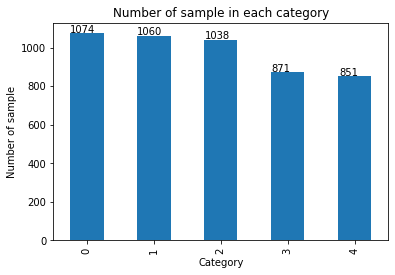

In [7]:
ax = pd.value_counts(data_df['label']).plot(kind="bar")
ax.set_xlabel('Category')
ax.set_ylabel('Number of sample')
ax.set_title('Number of sample in each category')

value_to_top_bar(ax)

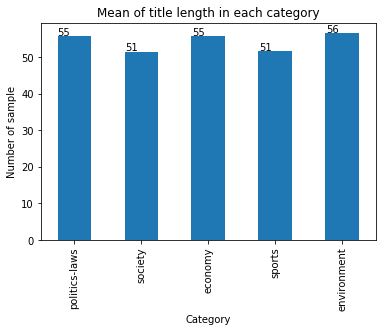

In [8]:
display_sr = pd.Series()
for i,label in enumerate(data_df['label'].unique()):
    display_sr.at[label_name[i]] = data_df.loc[data_df['label'] == label]['title'].str.len().mean()
    
ax = display_sr.plot(kind='bar')
ax.set_xlabel('Category')
ax.set_ylabel('Number of sample')
ax.set_title('Mean of title length in each category')

value_to_top_bar(ax)

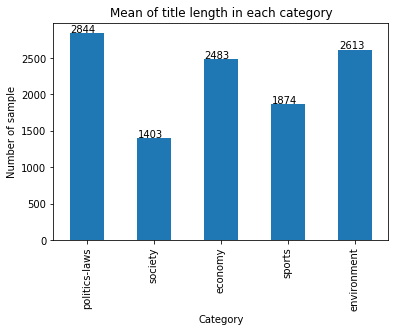

In [9]:
display_sr = pd.Series()
for i,label in enumerate(data_df['label'].unique()):
    display_sr.at[label_name[i]] = data_df.loc[data_df['label'] == label]['text'].str.len().mean()
    
ax = display_sr.plot(kind='bar')
ax.set_xlabel('Category')
ax.set_ylabel('Number of sample')
ax.set_title('Mean of title length in each category')

value_to_top_bar(ax)

In [10]:
y_sr = data_df["label"]
X_df = data_df.drop("label", axis=1)

## 3. Tiền xử lý dữ liệu

In [11]:
# Module được thực hiện đầu Pipeline, xóa các khoảng trắng liên tiếp, các ký tự: \n, \t, ...

class RemoveIrrelevant(BaseEstimator, TransformerMixin):
    @staticmethod
    def clean_str(string):
        string = re.sub(r"\\xa0", " ", string)
        string = re.sub(r"\'s", "", string)
        string = re.sub(r"\'ve", "", string)
        string = re.sub(r"n\'t", "", string)
        string = re.sub(r"\'re", "", string)
        string = re.sub(r"\'d", "", string)
        string = re.sub(r"\'ll", "", string)
        string = re.sub(r"'", "", string)
        string = re.sub(r"\\n", " ", string)
        string = re.sub(r"\\t", " ", string)
        string = re.sub(r"\s{2,}", " ", string) # Consecutive spaces
        return string.strip()
    
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        transform_X_df = X_df.copy(deep=True)
        transform_X_df['title'] = transform_X_df['title'].apply(lambda x: self.clean_str(x))
        transform_X_df['text'] = transform_X_df['text'].apply(lambda x: self.clean_str(x))
        return transform_X_df

### 3.1.  Chọn các đặc trưng
+ Số ký tự văn bản
+ Số từ trong văn bản
+ Số lượng dấu cảm thán (!, ?)
+ Số chữ cái viết hoa
+ Số chữ cái viết thường
+ Các giá trị TF-IDF cho các từ trong văn bản (có xử lý văn bản trước đó), có những ưu tiên cho các từ trong title

#### 3.1.1 Các đặc trưng cơ bản

In [12]:
class NumTextCharFeature(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        return np.array([X_df['text'].apply(lambda x: len(x)).values], \
                        dtype=np.float).transpose()
    
class NumTextTokenFeature(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        return np.array([X_df['text'].apply(lambda x: len(x.split(' '))).values], \
                        dtype=np.float).transpose()
    
    
class NumTextExclamationMarkFeature(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        return np.array([X_df['text'].apply(lambda x: (x.count('!')+x.count('?'))).values], \
                        dtype=np.float).transpose()
    
class NumTextLowerCaseFeature(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        return np.array([X_df['text'].str.count(r'[a-z]').values], \
                        dtype=np.float).transpose()

class NumTextUpperCaseFeature(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        return np.array([X_df['text'].str.count(r'[A-Z]').values], \
                        dtype=np.float).transpose()


In [13]:
# TEST CELL
pl = NumTextCharFeature()
transform_X = pl.transform(X_df)
print(transform_X)

pl = NumTextExclamationMarkFeature()
transform_X = pl.transform(X_df)
print(transform_X)

[[5539.]
 [1789.]
 [1958.]
 ...
 [1024.]
 [ 675.]
 [4332.]]
[[4.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


#### 3.1.2 TF-IDF

In [14]:
# Các module tiền xử lý trước khi tính tf-idf
class RemoveTone(BaseEstimator, TransformerMixin):
    @staticmethod
    def remove_tone(text):
        return unidecode.unidecode(text)
    
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        transform_X_df = X_df.copy(deep=True)
        transform_X_df['title'] = transform_X_df['title'].apply(lambda x: self.remove_tone(x))
        transform_X_df['text'] = transform_X_df['text'].apply(lambda x: self.remove_tone(x))
        return transform_X_df
    

class LowerCase(BaseEstimator, TransformerMixin):
    @staticmethod
    def lower_case(text):
        return text.lower()
    
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        transform_X_df = X_df.copy(deep=True)
        transform_X_df['title'] = transform_X_df['title'].apply(lambda x: self.lower_case(x))
        transform_X_df['text'] = transform_X_df['text'].apply(lambda x: self.lower_case(x))
        return transform_X_df
    

class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [15]:
# TEST CELL
# rm_tone = LowerCase()
# rm_tone.transform(X_df)
# title_tfidf = TitleTfidf()
# title_tfidf.fit_transform(X_df)

## 4. Thiết kế mô hình hoàn chỉnh

### 4.0. Mô hình hoàn chỉnh

In [16]:
general_features_pipeline = Pipeline([
    ('general_features', FeatureUnion([
        ('num_text_char_feature', NumTextCharFeature()),
        ('num_text_token_feature', NumTextTokenFeature()),
        ('num_text_exclamation_mark_feature', NumTextExclamationMarkFeature()),
        ('num_text_lower_case_feature', NumTextLowerCaseFeature()),
        ('num_text_upper_case_feature', NumTextUpperCaseFeature())
    ])),
    ('scaler', StandardScaler())
])

tfidf_features_pipeline = Pipeline([
    ('remove_tone', RemoveTone()),
    ('lower_case', LowerCase()),
    ('tfidf_feature', FeatureUnion([
        ('title_tfidf_features', Pipeline([
            ('selector', ItemSelector(key='title')),
            ('tfidf', TfidfVectorizer()),
        ])),
        ('text_tfidf_features', Pipeline([
            ('selector', ItemSelector(key='text')),
            ('tfidf', TfidfVectorizer()),
            ('best', TruncatedSVD(n_components=50))
        ]))
    ]))
])

model = linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000)
full_pipeline = Pipeline([
    ('remove_irrelevant', RemoveIrrelevant()),
    ('features', FeatureUnion([
        ('general_features_pipeline', general_features_pipeline),
        ('tfidf_features_pipeline', tfidf_features_pipeline)
    ])),
    ('classifier', model)
])

### 4.2. Khai báo các classifier

In [17]:
clf_list = []

# classifier parameters config
hyper_params_cfg = {
    'mlp':{
        'hidden_layer_sizes': [],
        'activation': [],
        'solver': []
    },
    'svm':{
        'param1': [],
        'param2': []
    }
}


### 4.3. Huấn luyện

In [18]:
k_fold = KFold(n_splits=5)
scores = []

for i, (train_index, valid_index) in enumerate(k_fold.split(X_df)):
    X_train, X_valid = X_df.iloc[train_index], X_df.iloc[valid_index]
    y_train, y_valid = y_sr.iloc[train_index], y_sr.iloc[valid_index]
    
    full_pipeline.fit(X_train, y_train)
    y_valid_predict = full_pipeline.predict(X_valid)
    
    score = metrics.accuracy_score(y_valid_predict, y_valid)
    scores.append(score)
    print('Fold {}, accuracy: {}'.format(i+1, score))

Fold 1, accuracy: 0.8712972420837589
Fold 2, accuracy: 0.8692543411644535
Fold 3, accuracy: 0.8518896833503575
Fold 4, accuracy: 0.8723186925434117
Fold 5, accuracy: 0.8445807770961146


## 5. Kết quả

In [19]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)

[[186  13   1   1   6]
 [ 18 142  17   4  25]
 [  6  18 189   0   4]
 [  1   3   2 155   1]
 [  2  24   6   0 154]]


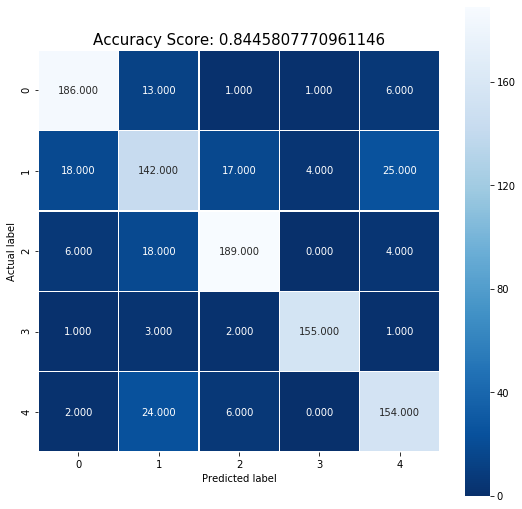

In [20]:
cm = metrics.confusion_matrix(y_valid, y_valid_predict)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);
